# Hybrid Quantum-Classical Classifier

## Imports

In [1]:
import numpy as np
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from tqdm.notebook import trange
from qiskit import QuantumCircuit
from qiskit.circuit.library import ZZFeatureMap, RealAmplitudes
from qiskit_machine_learning.neural_networks import EstimatorQNN
from qiskit_machine_learning.connectors import TorchConnector
from sklearn.metrics import classification_report
from wine_dataset import get_wine_dataloaders

## Hybrid Neural Network

In [2]:
def create_qnn():
    feature_map = ZZFeatureMap(2)
    ansatz = RealAmplitudes(2, reps=1)
    qc = QuantumCircuit(2)
    qc.compose(feature_map, inplace=True)
    qc.compose(ansatz, inplace=True)
    return EstimatorQNN(
        circuit=qc,
        input_params=feature_map.parameters,
        weight_params=ansatz.parameters,
        input_gradients=True,
    )


class Net(nn.Module):
    def __init__(self, qnn):
        super().__init__()
        self.fc1 = nn.Linear(2, 2)
        self.qnn = TorchConnector(qnn)
        self.fc2 = nn.Linear(1, 2)

    def forward(self, x):
        x = nn.functional.relu(self.fc1(x))
        x = self.qnn(x)
        x = self.fc2(x)
        return nn.functional.log_softmax(x, dim=1)

## Helper Functions

In [3]:
def train_model(train_loader, model, optimizer, loss_func, epochs=1):
    total_samples = len(train_loader.dataset)
    t = trange(epochs * total_samples // batch_size - 1)
    for _ in range(epochs):
        for _, (data, target) in enumerate(train_loader):
            optimizer.zero_grad()
            output = model(data)
            loss = loss_func(output, target)
            loss.backward()
            optimizer.step()
            t.set_postfix(quality=target[0].item(), loss=loss.item())
            t.update(1)


def evaluate_model(test_loader, model):
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for data, target in test_loader:
            output = model(data)
            _, predicted = torch.max(output.data, 1)
            y_true.extend(target.numpy())
            y_pred.extend(predicted.numpy())
    print(classification_report(y_pred, y_true))

## Training

In [4]:
epochs = 10
batch_size = 1

train_loader, test_loader, class_weights = get_wine_dataloaders(batch_size=batch_size)
class_weights_tensor = torch.tensor(class_weights).float()

qnn = create_qnn()
model = Net(qnn)
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_func = nn.NLLLoss(weight=class_weights_tensor)

train_model(train_loader, model, optimizer, loss_func, epochs)
torch.save(model.state_dict(), "model.pt")

  0%|          | 0/12789 [00:00<?, ?it/s]

## Evaluating

In [5]:
evaluate_model(test_loader, model)

              precision    recall  f1-score   support

           0       0.65      0.70      0.67       132
           1       0.78      0.74      0.76       188

    accuracy                           0.72       320
   macro avg       0.71      0.72      0.72       320
weighted avg       0.73      0.72      0.72       320



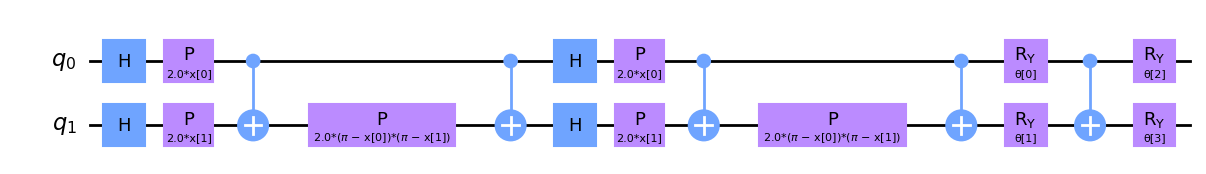

In [34]:
model.qnn.neural_network.circuit.decompose().draw('mpl')